# Header

### Goal
area / intensity와 퍼진 정도간의 연관성이 있는가? - 2nd dataset

1. 기존과 같이, global t2m & z500 mean을 비교  
    1. date 설정: 6일 뒤; 2021-06-27일  
    2. GC: GC - original 
    3. NWP: NWP - mean  
    4. 새로운 file로 저-장

2. perturbation region size와 intensity간의 연관성 확인
    1. data: global avg t2m & z500 
    2. x-axis: datapoint 수
    3. y-axis: spread


In [2]:
import glob
import re
import xarray as xr
import numpy as np
import pandas as pd
import pickle
from his_preprocess import *

# Load Data

In [3]:
#@ load data

# target_var = {"2m_temperature": "t2m", "geopotential": "z500"}
target_var = {"2m_temperature": "t2m"}
target_date = 6 # 2021-06-27

# nwp: 50개 ensemble
nwp = {}
# nwp_mean: 50개 ensemble의 평균
nwp_mean = {}

# gc_sample: 30개 * var 2개 
gc_sample = {}
# gc_original: var 2개 각각의 평균
gc_original = {}

for key, value in target_var.items():
    nwp[key] = xr.open_dataset(f"/data/GC_output/analysis/percent/nwp_{value}_GlobAvg.nc")
    nwp_mean[key] = nwp[key].mean(dim="ensemble")
    nwp[key] -= nwp_mean[key]

    with open(f"/data/GC_output/analysis/percent2/GC_{value}_GlobAvg.pkl", "rb") as f:
        gc_sample[key] = pickle.load(f)

    with open(f"/data/GC_output/analysis/percent2/zoom_GC_{value}_GlobAvg.pkl", "rb") as f:
        gc_sample[key].extend(pickle.load(f))

    gc_original[key] = xr.open_dataset("/data/GC_output/2021-06-21/GC_output.nc")
    gc_original[key] = weighted_mean(preprocess_GC(gc_original[key], key)[key])
# gc_sample["2m_temperature"]

KeyboardInterrupt: 

In [ ]:
nwp["2m_temperature"]

In [26]:
#@ gc_sample 추가 processing

from concurrent.futures import ThreadPoolExecutor
import itertools

def process_item(args):
    target_var, n = args
    if n >= len(gc_sample[target_var]):
        return None
    
    filename = gc_sample[target_var][n][0]
    color = gc_sample[target_var][n][1]
    value = (gc_sample[target_var][n][2] - gc_original[target_var])[target_var].values
    return (target_var, (filename, color, value))

with ThreadPoolExecutor() as executor:
    results = executor.map(process_item, 
                         itertools.product(list(target_var.keys()), range(94)))

gc_sample = {'2m_temperature': [], 'geopotential': []}
for r in results:
    if r is not None:
        var, item = r
        gc_sample[var].append(item)

# Plot

모든 데이터 준비는 끝났땅! 이제 그림을 그려볼까요?

In [27]:
# #@ plot 1

# import plotly.graph_objs as go
# import plotly.io as pio
# import pandas as pd

# # for target_var in ["2m_temperature", "geopotential"]:
# for target_var in ["2m_temperature"]:    
#     if target_var == '2m_temperature':
#         title = 'Mean 2m Temperature spread on  / 2021-06-21  + 7 days'
#         unit = 'Temperature (K)'
#     elif target_var == 'geopotential':
#         title = 'Mean 500hPa Geopotential Forecast / 2021-06-21  + 7 days'
#         unit = 'Geopotential (m^2/s^2)'

#     # Plot perturbation datasets with enhanced legend grouping
#     perturb_lines = []
#     partition_groups = {}

#     for label, color, dataset in gc_sample[target_var]:
#         partition_name = label.split()[0]
#         if partition_name not in partition_groups:
#             partition_groups[partition_name] = []
        
#         # Convert color to RGB if it's a tuple
#         if isinstance(color, tuple):
#             color = f'rgb({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)})'
        
#         # Create trace
#         trace = go.Scatter(
#             x=[pd.Timestamp('2021-06-22'), pd.Timestamp('2021-06-28')],
#             y=dataset,
#             mode='lines',
#             line=dict(color=color, width=1),
#             name=label[4:],
#             legendgroup=partition_name,
#             legendgrouptitle=dict(
#                 text=partition_name,
#                 font=dict(size=14, color='black', family='Arial Bold')
#             ) if len(partition_groups[partition_name]) == 0 else None,
#             showlegend=True
#         )
#         partition_groups[partition_name].append(trace)
#         perturb_lines.append(trace)

#     df = nwp[target_var].to_dataframe().reset_index()

#     # Add ensemble lines
#     ensemble_legend_shown = False  # Flag to control legend display
#     for ensemble in df['ensemble'].unique():
#         subset = df[df['ensemble'] == ensemble]
#         trace = go.Scatter(
#             x=subset['date'],
#             y=subset[target_var],
#             mode='lines',
#             line=dict(color='grey', width=0.5),
#             opacity=0.5,
#             name='Ensemble Members' if not ensemble_legend_shown else None,
#             showlegend=not ensemble_legend_shown,
#             legendgroup='Ensemble Members',
#             legendgrouptitle=dict(
#                 text='Ensemble Members',
#                 font=dict(size=14, color='black', family='Arial Bold')
#             ) if not ensemble_legend_shown else None,
#         )
#         perturb_lines.append(trace)
#         ensemble_legend_shown = True  # Only show legend once

#     # Add ensemble mean line
#     mean_temp = df.groupby('date')[target_var].mean().reset_index()
#     ensemble_mean_line = go.Scatter(
#         x=mean_temp['date'],
#         y=mean_temp[target_var],
#         mode='lines',
#         line=dict(color='black', width=2),
#         name='Ensemble Mean',
#         legendgroup='Ensemble Mean',
#         legendgrouptitle=dict(
#             text='Ensemble Mean',
#             font=dict(size=14, color='black', family='Arial Bold')
#         ),
#         showlegend=True
#     )
#     perturb_lines.append(ensemble_mean_line)

#     # Calculate y-axis range
#     y_values = []
#     for _, _, dataset in gc_sample[target_var]:
#         y_values.extend(dataset)
#     y_values.extend(df[target_var].values)  # Include ensemble data
#     y_min = np.min(y_values)
#     y_max = np.max(y_values)
#     y_range = y_max - y_min
#     y_padding = y_range * 0.05

#     # Create the layout
#     layout = go.Layout(
#         title=title,
#         xaxis=dict(
#             title='Date', 
#             range=[pd.Timestamp('2021-06-22'), pd.Timestamp('2021-06-28')]
#         ),
#         yaxis=dict(
#             title=unit,
#             range=[y_min - y_padding, y_max + y_padding],
#             tickformat='.0f'
#         ),
#         margin=dict(l=40, r=40, t=40, b=40),
#         height=900,
#         width=1600,
#         template='plotly_white',
#         legend=dict(
#             title=dict(
#                 text='Legend',
#                 font=dict(size=16)
#             ),
#             orientation='v',
#             x=1.05,
#             y=1,
#             itemsizing='constant',
#             groupclick='toggleitem',
#             itemclick='toggle',
#             itemdoubleclick='toggleothers',
#             tracegroupgap=15,
#             font=dict(size=12),
#             grouptitlefont=dict(size=14, color='black', family='Arial Bold'),
#             borderwidth=1,
#             bordercolor='rgba(0,0,0,0.2)',
#             bgcolor='rgba(255,255,255,0.95)',
#             traceorder='grouped'
#         )
#     )

#     # Create the figure
#     fig = go.Figure(data=perturb_lines, layout=layout)

#     # Save and display the figure
#     fig.write_html(f"{target_var}_intensity_spread_zoom.html")
#     pio.show(fig)

# per gridpoint percentage

위에서 뽑아낸 값 / grid point를 해보자. 어떻게 되나.

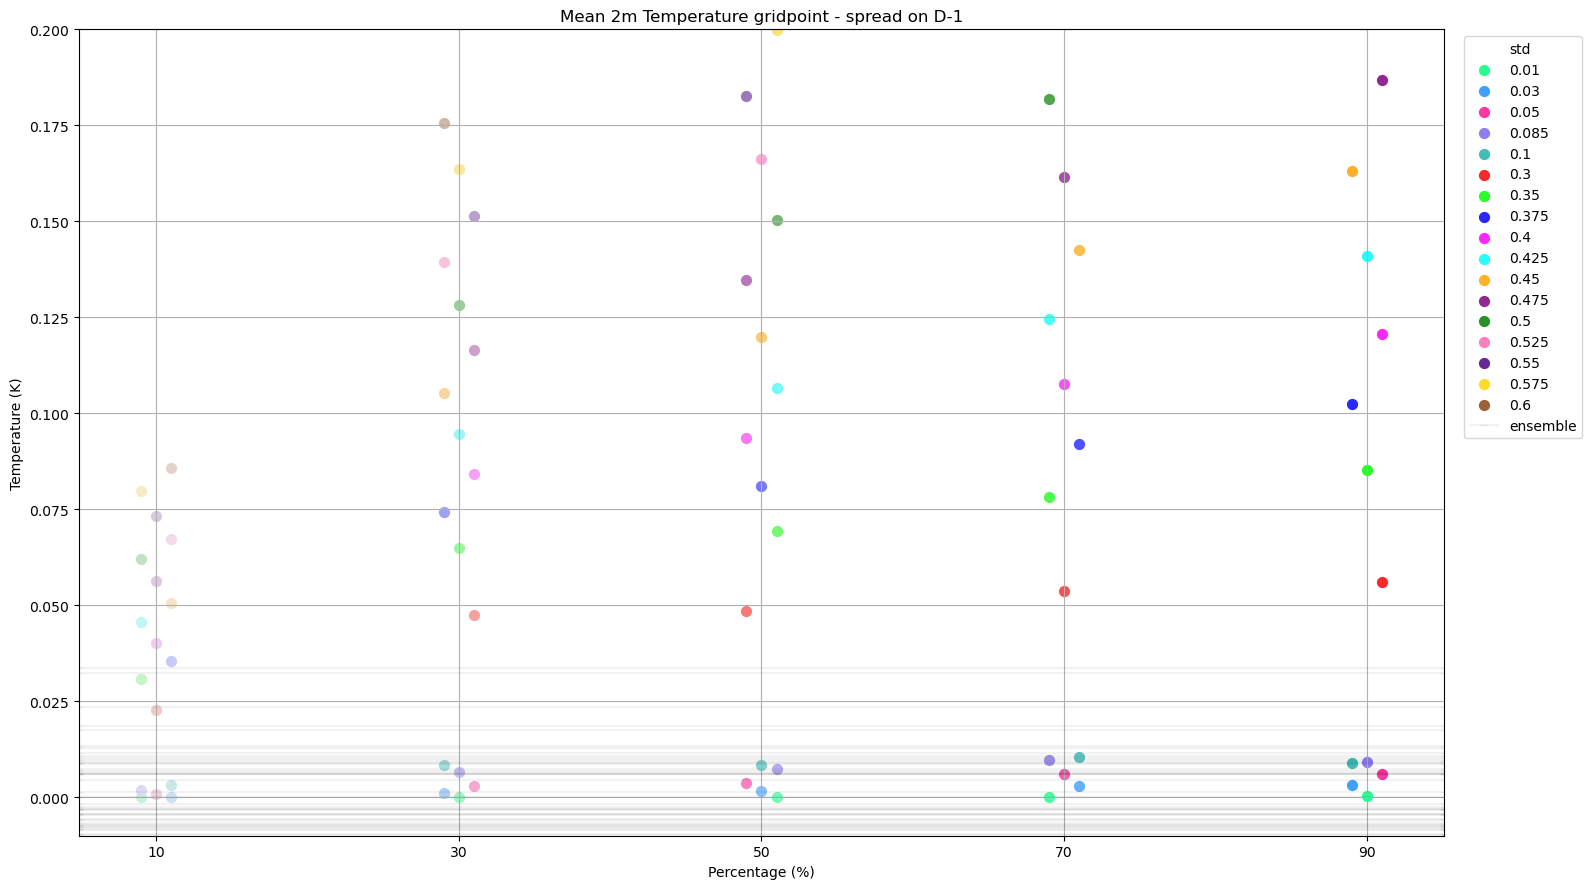

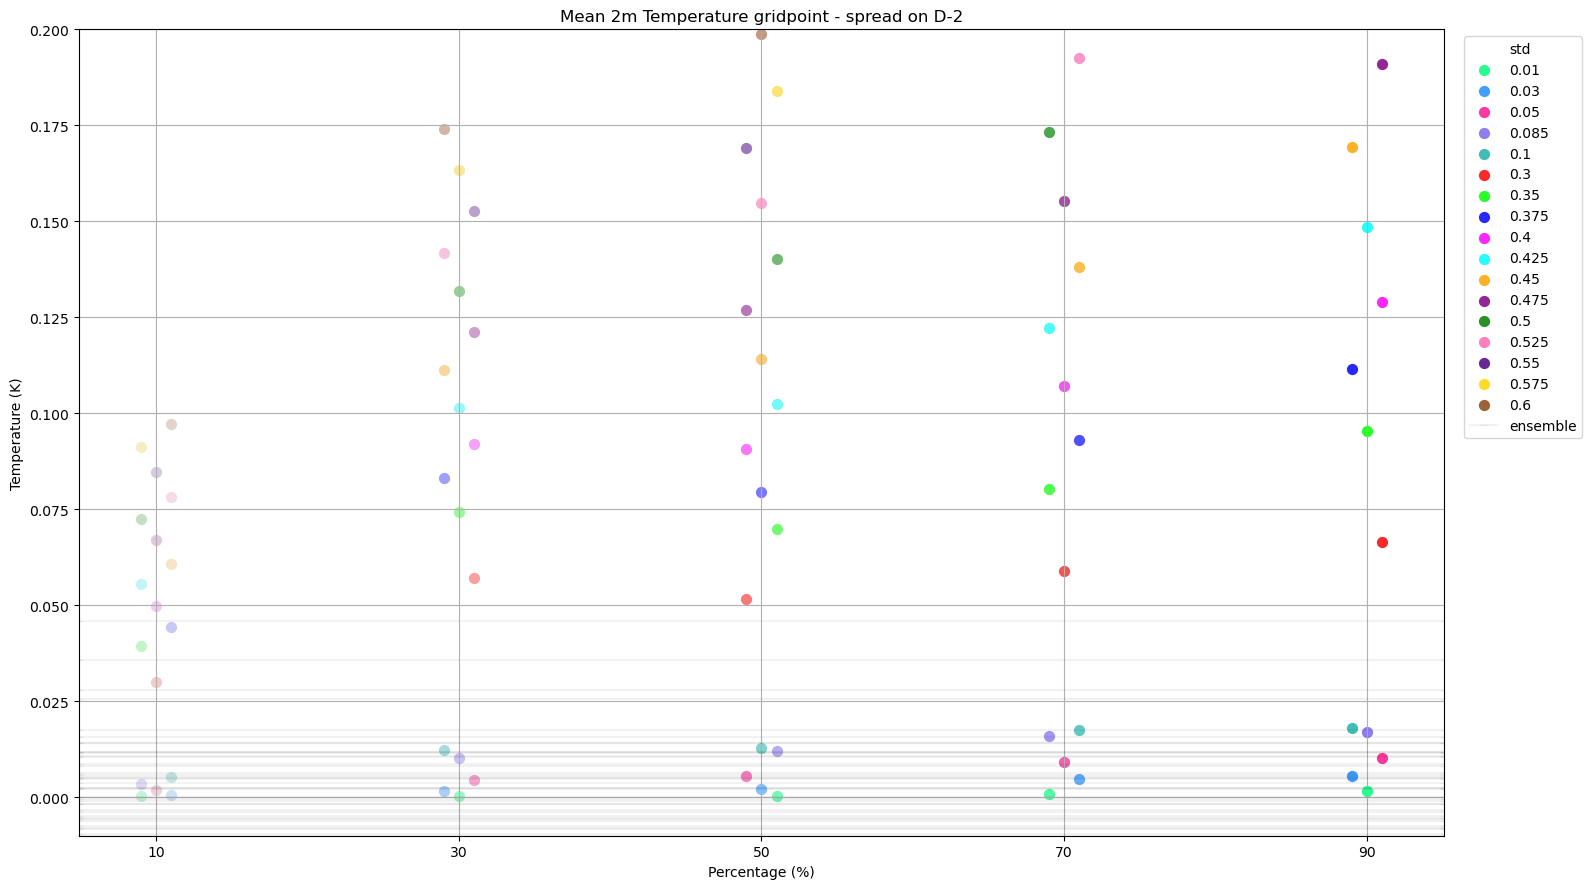

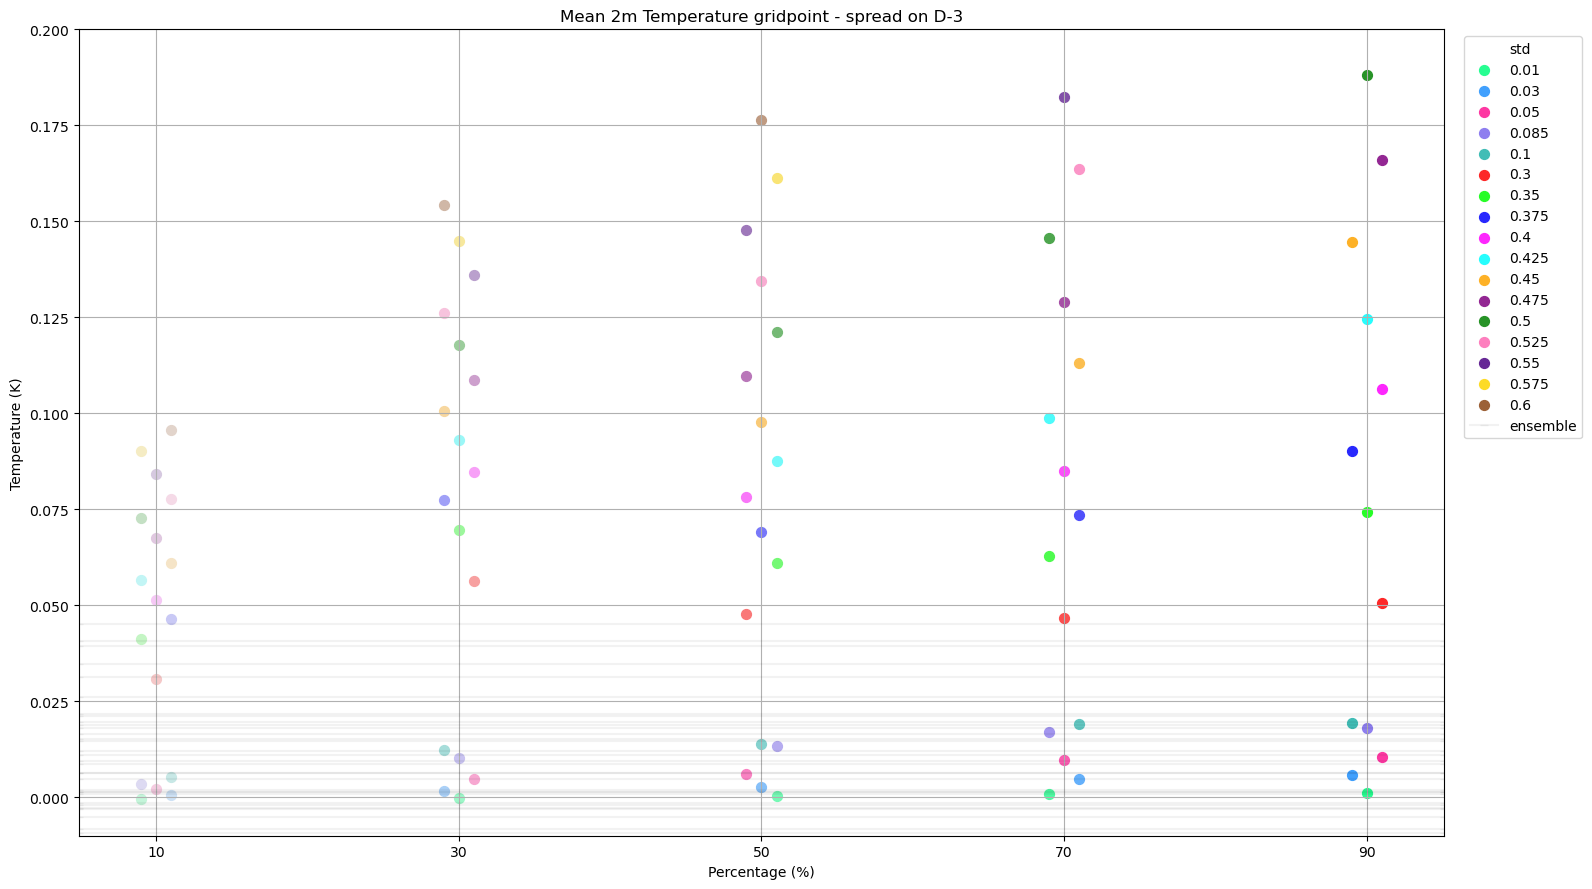

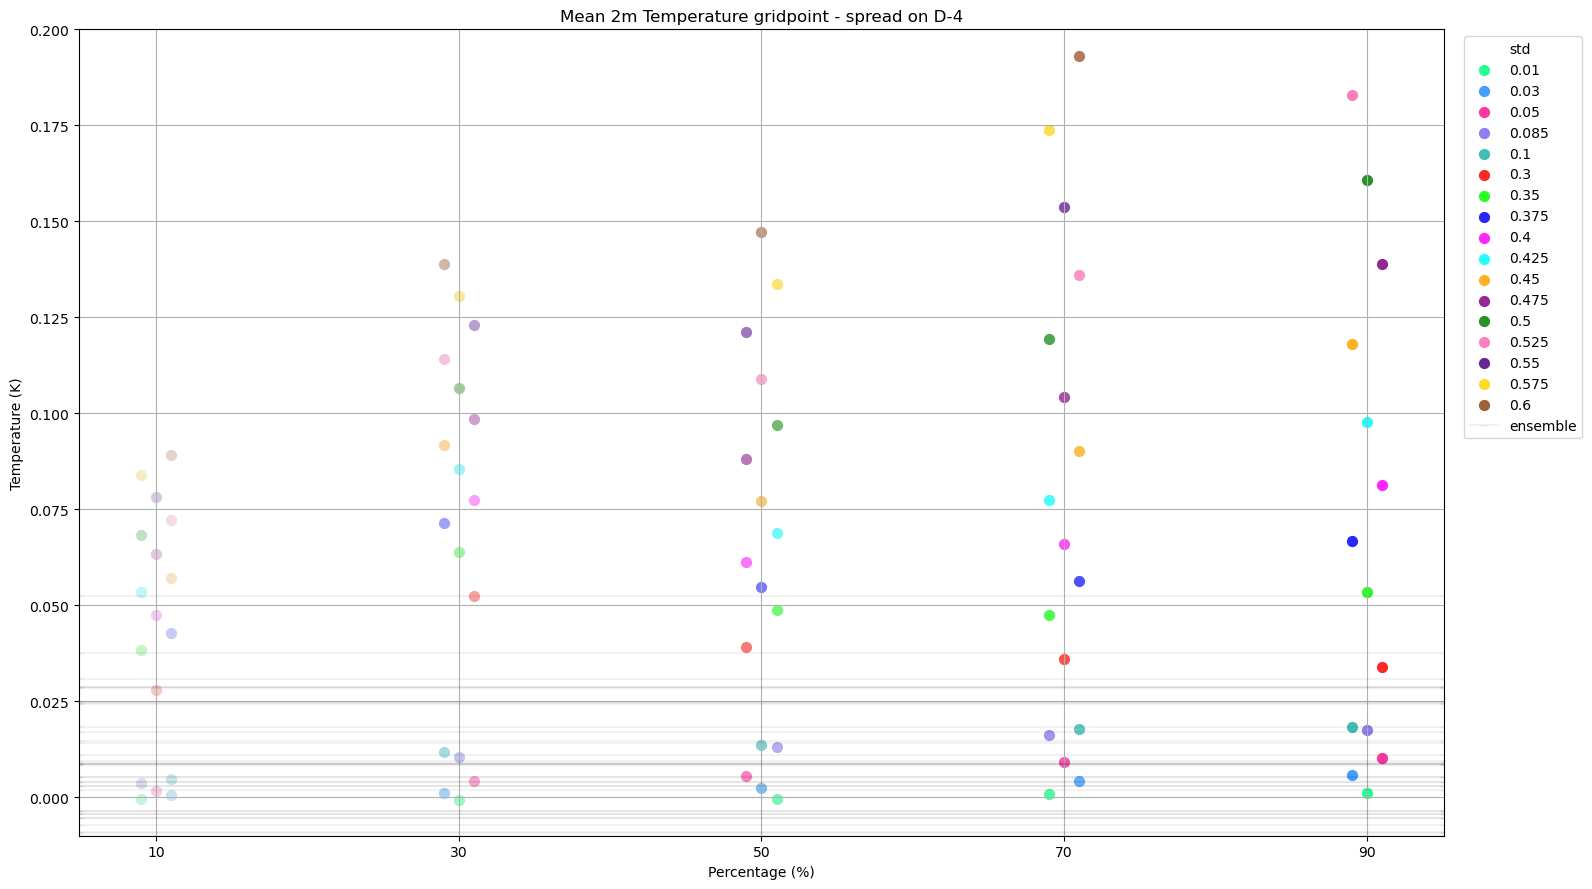

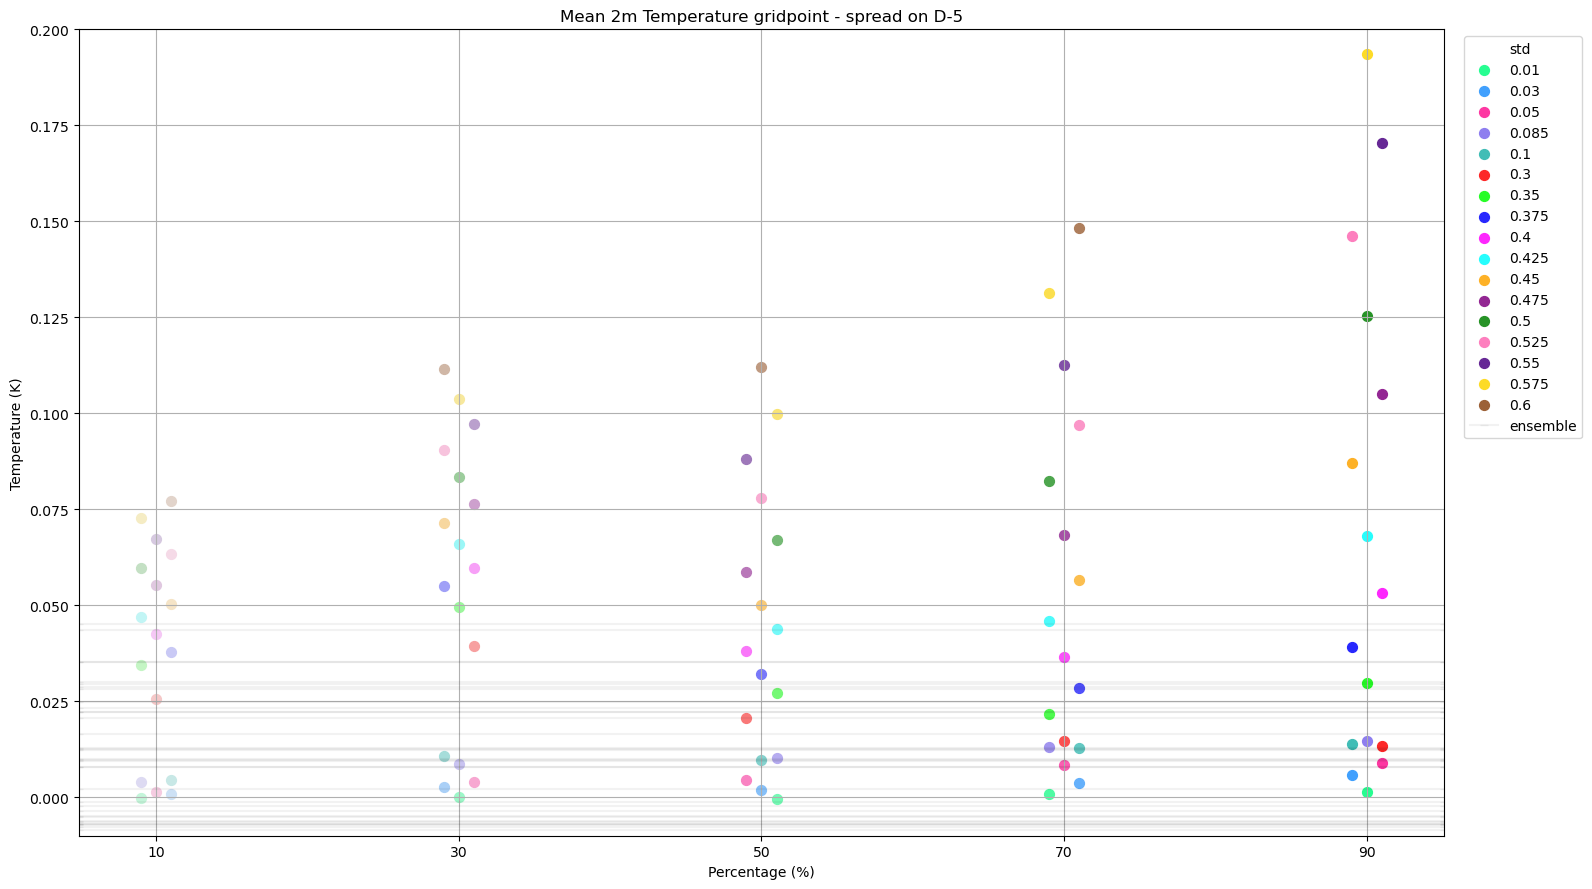

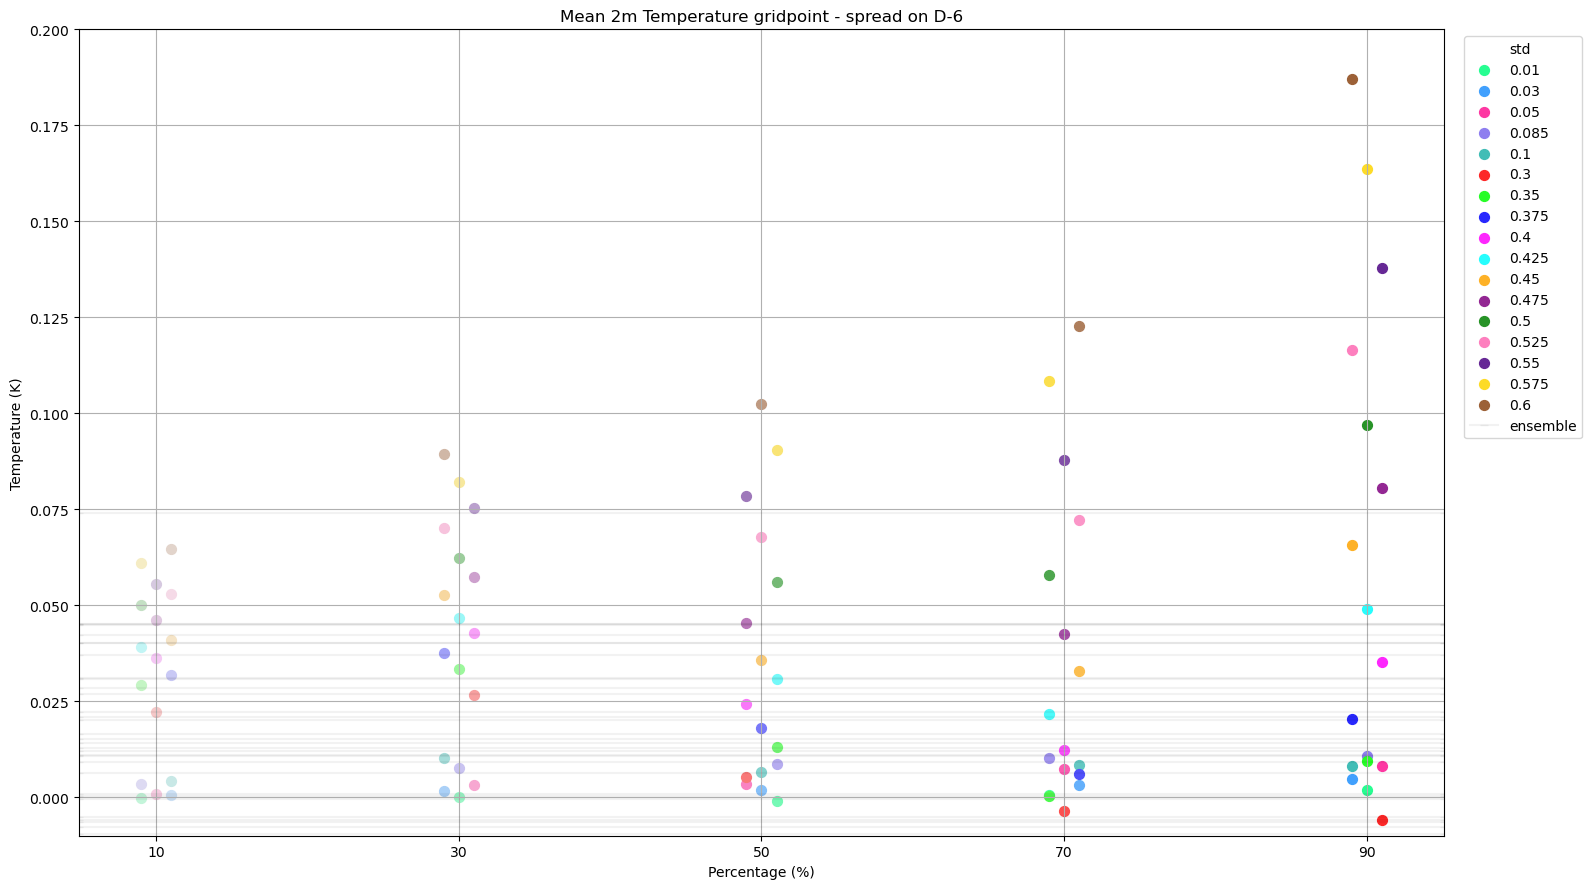

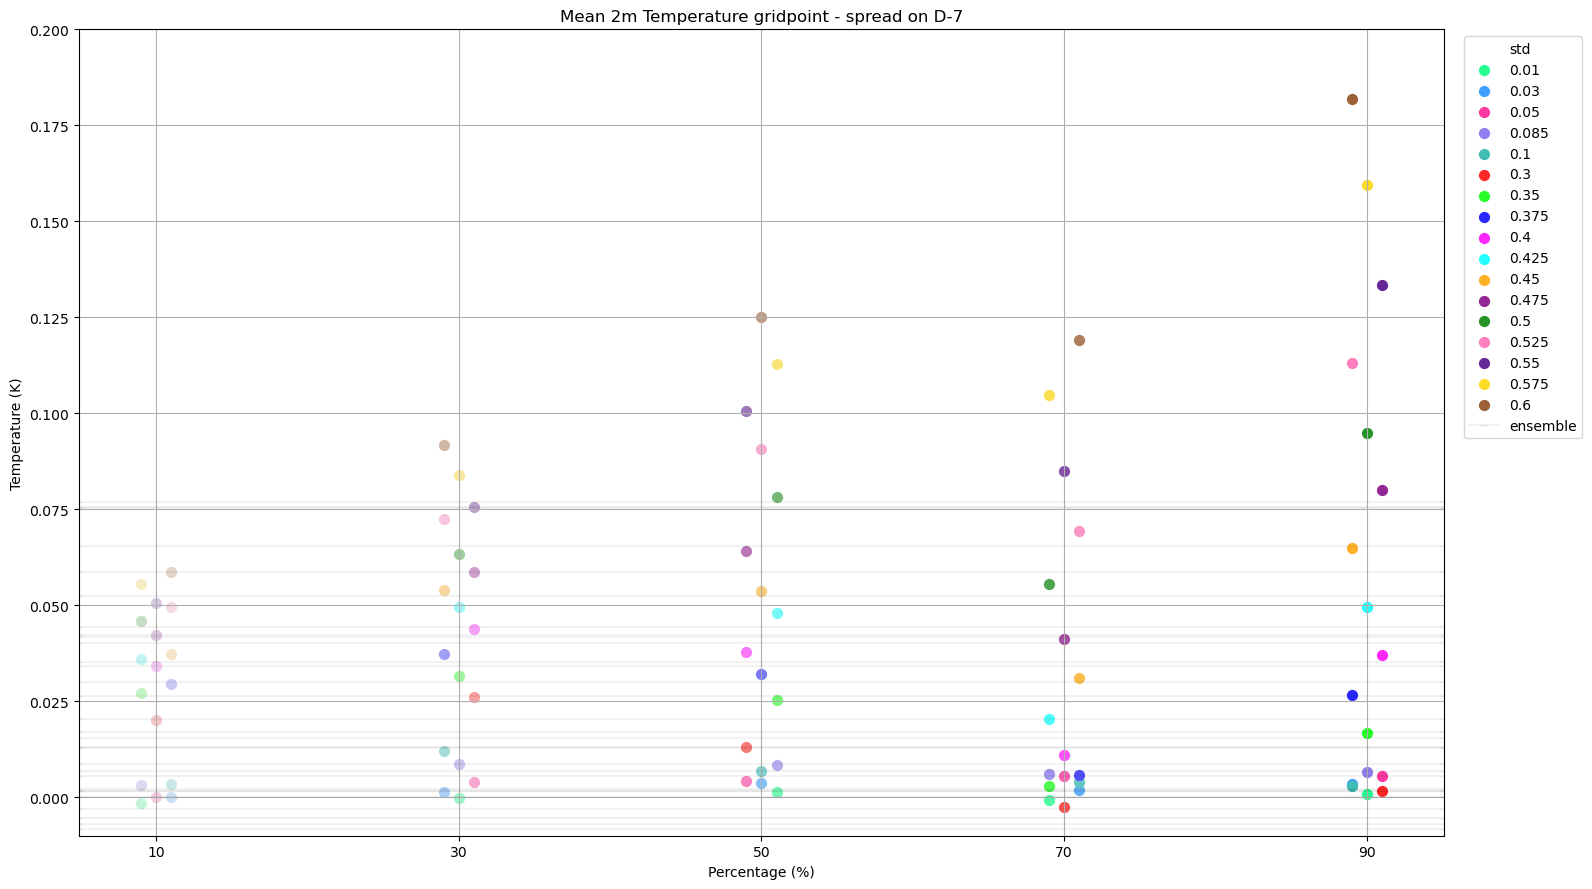

In [30]:
#@ plot2 gridpoint-spread

import matplotlib.pyplot as plt

# for target_var in ["2m_temperature", "geopotential"]:
for target_date in range(7):
    target_var = "2m_temperature"    
    if target_var == '2m_temperature':
        title = f'Mean 2m Temperature gridpoint - spread on D-{target_date+1}'
        unit = 'Temperature (K)'
    elif target_var == 'geopotential':
        title = f'Mean 500hPa Geopotential gridpoint - spread on D-{target_date+1}'
        unit = 'Geopotential (m^2/s^2)'

    plt.figure(figsize=(16, 9))

    plt.title(title)
    plt.xlabel("Percentage (%)")

    # 
    
    plt.xticks([10, 30, 50, 70, 90])
    plt.ylabel(unit)

    # plt.scatter(40, 0.9, color=(1, 1, 1), label="blue: all var", marker='o')
    # plt.scatter(40, 0.9, color=(1, 1, 1), label="green: only target", marker='o')
    # plt.scatter(40, 0.9, color=(1, 1, 1), label="red: except target", marker='o')
    
    plt.scatter(40, 0.9, color=(1, 1, 1), label="std", marker='o')
    for i, (name, color, data) in enumerate(gc_sample[target_var]):
        # percent = int(name.split()[1].split("_")[1][0])*10
        # name = name.split()[1]
        # std = name.split("_")[0]

        percent = float(name.split("_")[1])
        std = float(name.split("_")[0])

        offset = (i%3 -1) * 1
        # if float(std) > 0.5:
        #     continue
        if percent == 90:
            plt.scatter(percent+offset, data[target_date], color=color, label=f"{std}", marker='o', s=50) # {std}-{percent}%
        else:
            plt.scatter(percent+offset, data[target_date], color=color, marker='o', s=50)

    legend_shown=False
    for i, (value) in enumerate(nwp[target_var].isel(date=target_date)[target_var]):
        if not legend_shown:
            plt.axhline(y = value, color=(0.0000001, 0.0000001, 0.0000001), label="ensemble", marker='_', alpha=.05)
            legend_shown=True
        plt.axhline(y = value, color=(0.0000001, 0.0000001, 0.0000001), marker='_', alpha=.05)
    plt.ylim(-0.01, 0.2)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True)
    plt.subplots_adjust(right=0.85)
    plt.tight_layout()
    plt.savefig(f"{target_var}_gridpoint_spread_zoom_D-{target_date+1}.png")

# Date - Spread

시간에 따라 어떻게 변화하는가?
### 1) daily global mean

In [1]:
nwp

NameError: name 'nwp' is not defined

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_dataarray()` method.

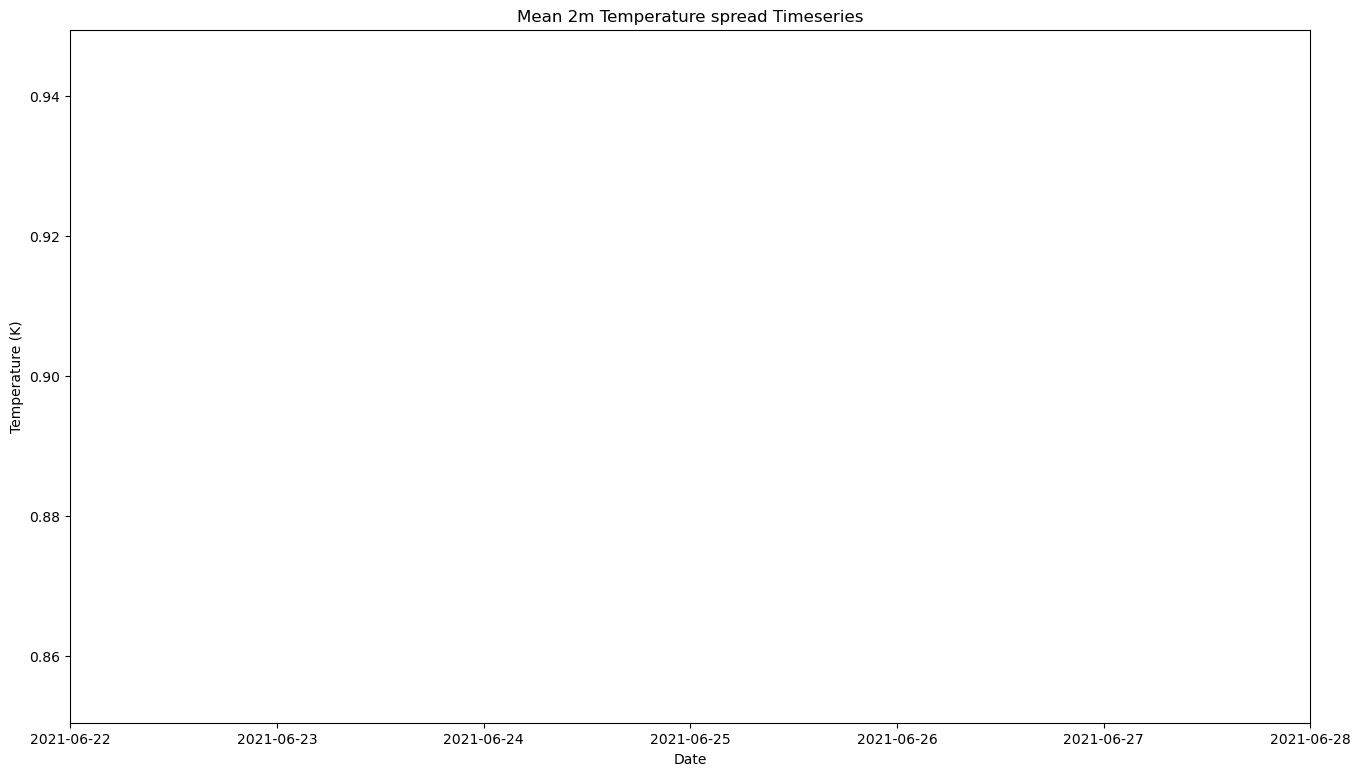

In [4]:
#@ plot3 date - spread

import matplotlib.pyplot as plt
# for target_var in ["2m_temperature", "geopotential"]:
target_var = "2m_temperature"   
title = f'Mean 2m Temperature spread Timeseries'
unit = 'Temperature (K)'

plt.figure(figsize=(16, 9))
plt.title(title)
plt.xlabel("Date")
# x axis: 2022-06-22 ~ 2022-06-28
date = pd.date_range(start='2021-06-22', end='2021-06-28')
plt.xlim(date[0], date[-1])
plt.ylabel(unit)

plt.scatter(40, 0.9, color=(1, 1, 1), label="std", marker='o')

for i, (name, color, data) in enumerate(gc_sample[target_var]):
    # percent = int(name.split()[1].split("_")[1][0])*10
    # name = name.split()[1]
    # std = name.split("_")[0]
    percent = float(name.split("_")[1])
    std = float(name.split("_")[0])

    offset = (i%5 -1) * 1
    # if float(std) > 0.5:
    #     continue
    if percent == 90:
        plt.plot(date, data, color=color, label=f"{std}", marker='o', markersize=5) # {std}-{percent}%
    else:
        plt.plot(date, data, color=color, marker='o', markersize=5)

legend_shown=False
for i in range(nwp[target_var].sizes["ensemble"]):
    if not legend_shown:
        plt.plot(date, nwp[target_var].isel(ensemble=i).squeeze()["2m_temperature"], color=(0.00001, 0.00001, 0.00001), label="ensemble", marker='_', alpha=.1)
        legend_shown=True
    plt.plot(date, nwp[target_var].isel(ensemble=i).squeeze()["2m_temperature"], color=(0.00001, 0.00001, 0.00001), marker='_', alpha=.1)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)
plt.ylim(-0.01, 0.35)
plt.subplots_adjust(right=0.85)
plt.tight_layout()
plt.savefig(f"zoom_{target_var}_spread_timeseries.png")

### 2) global mean but !daily

In [ ]:
from multiprocessing import Pool

with open(f"/data/GC_output/analysis/percent2/zoom_GC_t2m_Globraw.pkl", "rb") as f:
    t2m_perturb = pickle.load(f)

t2m_control = xr.open_dataset("/data/GC_output/2021-06-21/GC_output.nc")

# average global mean through multiprocessing

t2m_control = weighted_mean(t2m_control["2m_temperature"])


def process_t2m(args):
    n = args
    
    filename = t2m_control[n][0]
    color = t2m_control[n][1]
    value = (weighted_mean(t2m_control[n][2]) - t2m_control)
    return (filename, color, value)

with ThreadPoolExecutor() as executor:
    results = executor.map(process_t2m, range(len(t2m_perturb)))

t2m_processed = []
for item in results:
    if item is not None:
        t2m_processed.append(item)

In [ ]:
#@ plot3 date - spread

import matplotlib.pyplot as plt

# for target_var in ["2m_temperature", "geopotential"]:
target_var = "2m_temperature"   
title = f'Mean 2m Temperature spread Timeseries'
unit = 'Temperature (K)'

plt.figure(figsize=(16, 9))
plt.title(title)
plt.xlabel("Date")
# x axis: 2022-06-22 ~ 2022-06-28
date = pd.date_range(start='2021-06-22', end='2021-06-28')

plt.ylabel(unit)

plt.scatter(40, 0.9, color=(1, 1, 1), label="std", marker='o')
for name, color, data in t2m_processed:
    # percent = int(name.split()[1].split("_")[1][0])*10
    # name = name.split()[1]
    # std = name.split("_")[0]
    percent = float(name.split("_")[1])
    std = float(name.split("_")[0])

    # if float(std) > 0.5:
    #     continue
    if percent == 90:
        plt.plot(date, data, color=color, label=f"{std}", marker='o', markersize=5) # {std}-{percent}%
    else:
        plt.plot(date, data, color=color, marker='o', markersize=5)
legend_shown=False
for value in nwp[target_var][target_var]:
    if not legend_shown:
        plt.plot(date, value, color=(0.0000001, 0.0000001, 0.0000001), label="ensemble", marker='_', alpha=.05)
        legend_shown=True
    plt.plot(date, value, color=(0.0000001, 0.0000001, 0.0000001), marker='_', alpha=.05)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)
plt.subplots_adjust(right=0.85)
plt.tight_layout()
plt.savefig(f"{target_var}_spread_timeseries_detailed.png")